# DAT535 - Group 19 Project - Earthquake Analysis and Prediction
*Authors: Haakon Vollheim Webb, Håkon Nodeland* 

Content:
1. Data Ingestion
2. Data Cleaning
3. Data Serving Part 1 - Analysis
4. Data Serving Part 2 - Machine learning implementation

# 1. Data Ingestion

The dataset we want to use contains a collection of recorded earthquakes from 1990 to 2023.

We want to use the data to train a model to predict future earthquakes.
We want to see if it can predict both magnitude and position (in co-ordinates), and compare the results to the recorded earthquakes of 2024.

The ingestion method will be **manual download**.

The data was origninally in a .csv-format. We have unstructered the data by:
* Adding a random number of duplicates to a random number of rows.
* Removing the commas that originially were seperating the values.

The raw data can be found in `data/unstructured.txt`.
We then distribute the data to hdfs, so the data can be accessed by the data nodes, and so that we can send map reduce functions to them.

In [34]:
# Start Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Earthquake_Predicter") \
    .master("spark://instance-1:7077") \
    .getOrCreate()


# Load dataset into an RDD
path = "raw_data/unstructured.txt"
rdd = spark.sparkContext.textFile(path)

# Print first line to ensure that we are redaing the correct file
print(f"First line: \n{rdd.first()}")

First line: 
timeplacestatustsunamisignificancedata_typemagnitudostatelongitude latitude depth date


# 2. Data Cleaning
We need to
1. delete the header
2. delete duplicate rows
3. structure the data into the fields and convert fields to their correct data types
4. handle missing or corrupted data (None, NaN)
5. validate data integrity

#### Data Cleaning - Step 1

In [35]:
# Step 1: Deleting the header

# Remove the header using zipWithIndex
rdd_with_index = rdd.zipWithIndex()

# Filter out the first line (index 0)
rdd_no_header = rdd_with_index.filter(lambda x: x[1] > 0).map(lambda x: x[0])

# Verify that the first line has been removed
print(f"First line after header removal:\n {rdd_no_header.first()}")

First line after header removal:
 1546899521050"187 km SE of Ust’-Kamchatsk Staryy, Russia"reviewed0271earthquake4.2 Russia164.4826 54.9776 10.0 2019-01-07 22:18:41.050000+00:00


#### Data Cleaning - Step 2

In [36]:
# Step 2: Remove all duplicate rows
rdd_unique = rdd_no_header.distinct()

# Verify that duplicates have been removed
print("Number of records before removing duplicates:", rdd_no_header.count())
print("Number of records after removing duplicates:", rdd_unique.count())

Number of records before removing duplicates: 3742243


Number of records after removing duplicates: 3428882


#### Data Cleaning - Step 3: Structure the data into fields header.

At this point, our data has the following structure:


1546899521050"187 km SE of Ust’-Kamchatsk Staryy, Russia"reviewed0271earthquake4.2 Russia164.4826 54.9776 10.0 2019-01-07 22:18:41.050000+00:00

Where the headers are the following:
time-ID-field-place-status-tsunami-significance-data_type-magnitudo-state-longitude latitude depth date
(Here we have used hyphens to seperate the headers, where as the data only has spaces between longitude, latitude, depth and date)

Field 1: 
Time-ID-field. This field is an integer, and it starts at the beginning of the row and ends when we reach a double quote"

Field 2: 
Place field. This field is a string, and it starts at the first double quote, and ends on the second.

Field 3: 
Status-field. This is a string field, and it starts at the right after the second double quote, and ends when it reaches any number.

Field 4: 
Tsunami-field. This field is boolean, and contains either 0 or 1. It starts where field 3 ends and contains one digit.

Field 5: 
Significance-field. This field is an integer field, and it starts right after field 4 and ends when it reaches any character.

Field 6: 
Data_type-field. This field is a string field. It begins right after field 5, and it ends when it before it reaches any number.

Field 7:
Magnitude-field. This field is a float-field. It begins right after field 6, and it ends when it reaches either a space or a letter.

Field 8: 
Longitude-field. This field is a float-field. It begins right after field 7, and it ends when it reaches a space.

Field 9: 
Latitude-field. This field is a float-field. It begins right after field 8, and it ends when it reaches a space.

Field 10: 
Depth-field. This field is a float-field. It begins right after field 9, and it ends when it reacehs a space.

Field 11: 
Date-field. This field is a datetime-field. It starts right after field 10, and it ends when it reaches the end of the row.


In [37]:
from datetime import datetime

# To accomplish this, we can create a parsing function:

def parse(line):
    try:
        # Field 1: time-ID-field
        time_id_start = 0
        time_id_end = line.find('"', time_id_start)
        if time_id_end == -1:
            raise ValueError("Double quote not found at the end of time-ID-field")
        time_id_str = line[time_id_start:time_id_end].strip()
        time_id = int(time_id_str)

        # Field 2:
        place_start = time_id_end + 1
        place_end = line.find('"', place_start)
        if place_end == -1:
            raise ValueError("Double quote not found at the end of place field")
        place_str = line[place_start:place_end].strip()
        
        
        # Field 3:
        counter = 1
        status_start = place_end + 1
        length = len(line)
        
        #Chat-GPT helped us to get this while loop to work.
        while (status_start + counter) < length and not line[status_start + counter].isdigit() and counter < 50: #counter < 50 to avoid infinite loops
            counter += 1
            
        if counter == 50: 
            raise ValueError("No digits found after status field")
        status_end = status_start + counter
        status_str = str(line[status_start:status_end]).strip().lower()
        
        
        # Field 4: 
        tsunami_start = status_end
        tsunami_end = tsunami_start + 1
        tsunami_bool = bool(int(line[tsunami_start:tsunami_end]))
        
        
        # Field 5:
        significance_start = tsunami_end
        counter = 1
        while ((significance_start + counter) < length) and line[significance_start + counter].isdigit() and counter < 50:
            counter += 1
        significance_end  = significance_start + counter
        significance_int = int(line[significance_start:significance_end])
        
        
        # Field 6:
        data_type_start = significance_end
        counter = 0
        while ((data_type_start + counter) < length) and not line[data_type_start + counter].isdigit():
            counter += 1    
        data_type_end = data_type_start + counter
        data_type_str = str(line[data_type_start:data_type_end])
    
    
        # Field 6:
        magnitude_start = data_type_end
        counter = 0
        while ((magnitude_start + counter) < length) and line[magnitude_start + counter].isdigit() or line[magnitude_start + counter] == '.':
            counter += 1    
        magnitude_end = magnitude_start + counter
        magnitude_float = float(line[magnitude_start:magnitude_end])
        
        
        #Field 7:
        
        state_start = magnitude_end
        counter = 0
        while ((state_start + counter) < length) and not line[state_start + counter].isdigit() and line[state_start + counter] != '-':
            counter += 1    
        state_end = state_start + counter
        state_str = str(line[state_start:state_end]).strip()
        
        
        # Field 8
        
        longitude_start = state_end
        counter = 0
        while ((longitude_start + counter) < length) and line[longitude_start + counter].isdigit() or line[longitude_start + counter] == '.' or line[longitude_start + counter] =='-':
            counter += 1
        longitude_end = longitude_start + counter
        longitude_float = float(line[longitude_start:longitude_end])
        
        # Field 9
        latitude_start = longitude_end
        counter = 1
        while ((latitude_start + counter) < length) and line[latitude_start + counter].isdigit() or line[latitude_start + counter] == '.' or line[latitude_start + counter] =='-':

            counter += 1

        latitude_end = latitude_start + counter
        latitude_float = float(line[latitude_start:latitude_end])
        
        
        # Field 10
        depth_start = latitude_end
        counter = 1
        while ((depth_start + counter) < length) and line[depth_start + counter].isdigit() or line[depth_start + counter] == '.' or line[depth_start + counter] =='-':

            counter += 1

        depth_end = depth_start + counter
        depth_float = float(line[depth_start:depth_end])
        
        # Field 11
        date_str = str(line[depth_end+1::])
        date = datetime.fromisoformat(date_str)
        # date_readable = date.strftime('%A, %B %d, %Y at %I:%M %p')
        
        return {
            "time_id": time_id,
            "place_str": place_str,
            "status_str": status_str,
            "tsunami_bool": tsunami_bool,
            "significance_int": significance_int,
            "data_type_str": data_type_str,
            "magnitude_float": magnitude_float,
            "state_str": state_str,
            "longitude_float": longitude_float,
            "latitude_float": latitude_float,
            "depth_float": depth_float,
            "date": date,
        }
            
    except Exception as e:
        return None

rdd_parsed = rdd.map(parse)
print(rdd_parsed.take(5))

[None, {'time_id': 1546899521050, 'place_str': '187 km SE of Ust’-Kamchatsk Staryy, Russia', 'status_str': 'reviewed', 'tsunami_bool': False, 'significance_int': 271, 'data_type_str': 'earthquake', 'magnitude_float': 4.2, 'state_str': 'Russia', 'longitude_float': 164.4826, 'latitude_float': 54.9776, 'depth_float': 10.0, 'date': datetime.datetime(2019, 1, 7, 22, 18, 41, 50000, tzinfo=datetime.timezone.utc)}, {'time_id': 1349582616420, 'place_str': '5 km SSW of Mammoth Lakes, California', 'status_str': 'reviewed', 'tsunami_bool': False, 'significance_int': 0, 'data_type_str': 'earthquake', 'magnitude_float': 0.07, 'state_str': 'California', 'longitude_float': -119.0005, 'latitude_float': 37.602, 'depth_float': 1.087, 'date': datetime.datetime(2012, 10, 7, 4, 3, 36, 420000, tzinfo=datetime.timezone.utc)}, {'time_id': 1246652229880, 'place_str': '57 km SE of Sand Point, Alaska', 'status_str': 'reviewed', 'tsunami_bool': False, 'significance_int': 104, 'data_type_str': 'earthquake', 'magnit

#### Data Cleaning - Step 4: Handle missing or corrupted data (None, NaN).
We want to apply a strict filter for our data, where no records containing None or "NaN" are let through. 


In [38]:
# Count data before applying any filters
parsed_count = rdd_parsed.count()
print(f"Number of records before filtering out None values: {parsed_count}")

# Filter out None
rdd_none_filtered = rdd_parsed.filter(lambda x: x is not None)
none_filtered_count = rdd_none_filtered.count()
print(f"Number of records after filtering out None: {none_filtered_count}. Removed {parsed_count - none_filtered_count} records. ({round(((parsed_count - none_filtered_count)/parsed_count)*100, 3)}%)")

# Filter out NaN
rdd_none_and_nan_filtered = rdd_none_filtered.filter(lambda x: "NaN" not in x)
nan_filtered_count = rdd_none_and_nan_filtered.count()
print(f"Number of records after filtering out NaN: {nan_filtered_count}. Removed {none_filtered_count - nan_filtered_count} records. ({round(((none_filtered_count - nan_filtered_count)/none_filtered_count)*100, 3)}%)")

Number of records before filtering out None values: 3742244


Number of records after filtering out None: 3600336. Removed 141908 records. (3.792%)


Number of records after filtering out NaN: 3600336. Removed 0 records. (0.0%)


#### Data Cleaning - Step 5: Vlidate data integrity.
Longitude should be in the range [-180, 180], and latitutde should be in the range [-90, 90].

In [39]:
# Validate longitude and latitude ranges
validated_rdd = rdd_none_and_nan_filtered.filter(lambda x: 
                                                 -180 <= x["longitude_float"] <= 180 and  # Longitude range
                                                 -90 <= x["latitude_float"] <= 90)      # Latitude range

# Count data after validation
validated_count = validated_rdd.count()
print(f"Number of records after validation: {validated_count}. Removed {nan_filtered_count - validated_count} records. ({round(((nan_filtered_count - validated_count) / nan_filtered_count) * 100, 3)}%)")


Number of records after validation: 3600336. Removed 0 records. (0.0%)


The data is now cleaned. We can convert it to a data frame to be used in Part 3:

In [40]:
from pyspark.sql.types import (
    StructType, StructField, LongType, StringType, BooleanType,
    IntegerType, FloatType, DoubleType, TimestampType
)

# Define the schema with appropriate data types
schema = StructType([
    StructField("time_id", LongType()),
    StructField("place_str", StringType()),
    StructField("status_str", StringType()),
    StructField("tsunami_bool", BooleanType()),
    StructField("significance_int", IntegerType()),
    StructField("data_type_str", StringType()),
    StructField("magnitude_float", FloatType()),
    StructField("state_str", StringType()),
    StructField("longitude_float", DoubleType()),
    StructField("latitude_float", DoubleType()),
    StructField("depth_float", DoubleType()),
    StructField("date", TimestampType())
])

# Create the DataFrame using the schema
df = spark.createDataFrame(validated_rdd, schema=schema)

# Show sample data
df.show(5)

+-------------+--------------------+----------+------------+----------------+-------------+---------------+----------+---------------+--------------+-----------+--------------------+
|      time_id|           place_str|status_str|tsunami_bool|significance_int|data_type_str|magnitude_float| state_str|longitude_float|latitude_float|depth_float|                date|
+-------------+--------------------+----------+------------+----------------+-------------+---------------+----------+---------------+--------------+-----------+--------------------+
|1546899521050|187 km SE of Ust’...|  reviewed|       false|             271|   earthquake|            4.2|    Russia|       164.4826|       54.9776|       10.0|2019-01-07 22:18:...|
|1349582616420|5 km SSW of Mammo...|  reviewed|       false|               0|   earthquake|           0.07|California|      -119.0005|        37.602|      1.087|2012-10-07 04:03:...|
|1246652229880|57 km SE of Sand ...|  reviewed|       false|             104|   earth

# 3. Data Serving - Part 1: Analysis
We want to visualize and analyse the dataset using sparks functionality. 
This section is has the following structure:

1. Total Earthquakes
2. Average Magnitude
3. Maximum and Minimum Magnitude
4. Earthquake Depth Distribution
5. Earthquakes by Status
6. Earthquakes by State
7. Earthquakes with Tsunamis
8. Most Significant Earthquakes
9. Earthquakes Trends over Time
10. Geospatial Distribution
12. Top 10 Most Frequent Locations
13. Tsunami Correlation with Magnitude


#### Analysis 1 - Total Earthquakes

In [41]:
analysis_rdd = validated_rdd
total_earthquakes = analysis_rdd.count()
print(f"From 1990 to 2023 there has been a total of { total_earthquakes } recorded earthquakes.")

From 1990 to 2023 there has been a total of 3600336 recorded earthquakes.


#### Analysis 2 - Average Magnitude

In [42]:
average_magnitude = analysis_rdd.map(lambda row: row['magnitude_float']).mean()
print(f"The average magnitude of recorded earthquakes is {average_magnitude:.2f}.")

The average magnitude of recorded earthquakes is 1.74.


#### Analysis 3 - Maximum and Minimum Magnitudes

In [ ]:
max_magnitude = analysis_rdd.map(lambda row: row["magnitude_float"]).max()
min_magnitude = analysis_rdd.map(lambda row: row["magnitude_float"]).min()

# Find the rows with the maximum and minimum magnitudes
max_magnitude_row = analysis_rdd.filter(lambda row: row["magnitude_float"] == max_magnitude).first()
min_magnitude_row = analysis_rdd.filter(lambda row: row["magnitude_float"] == min_magnitude).first()

# Extract the dates of the maximum and minimum magnitude earthquakes to display in the print.
max_magnitude_date = max_magnitude_row["date"]
min_magnitude_date = min_magnitude_row["date"]

print(f"The maximum recorded magnitude is {max_magnitude:.2f} in {max_magnitude_date.day}.{max_magnitude_date.month}.{max_magnitude_date.year}.")
print(f"The minimum recorded magnitude is {min_magnitude:.2f} in {min_magnitude_date.day}.{min_magnitude_date.month}.{min_magnitude_date.year}.")


The maximum recorded magnitude is 9.99 in 28.12.2008.
The minimum recorded magnitude is 0.00 in 19.8.2017.


#### Analysis 4 - Earthquake Depth Distribution (Mean, Min, Max, Std Dev)

Depth Distribution - Mean: 20.87 km, Min: -10.00 km, Max: 721.80 km, Std Dev: 45.51 km.


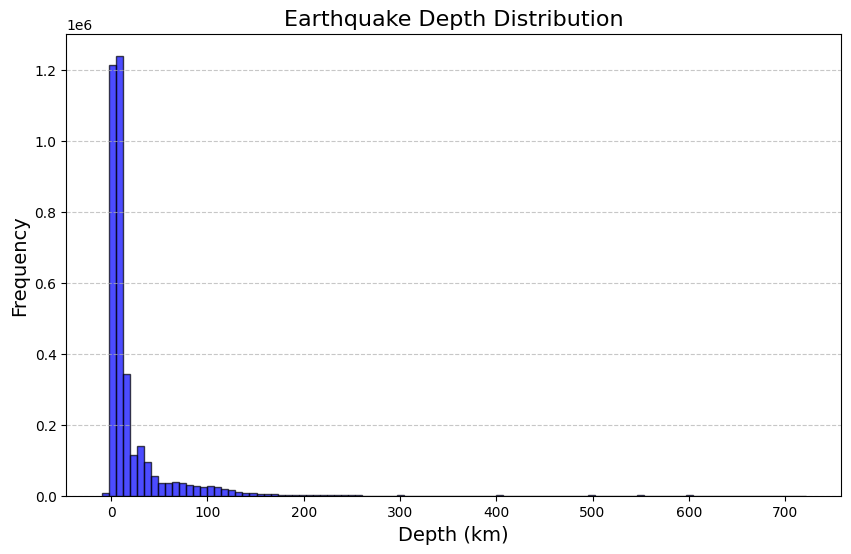

In [ ]:
import matplotlib.pyplot as plt
from math import sqrt

depths = analysis_rdd.map(lambda row: row['depth_float']).collect()
mean_depth = sum(depths) / len(depths)
min_depth = min(depths)
max_depth = max(depths)
std_dev_depth = sqrt(sum([(x - mean_depth) ** 2 for x in depths]) / len(depths))
print(f"Depth Distribution - Mean: {mean_depth:.2f} km, Min: {min_depth:.2f} km, Max: {max_depth:.2f} km, Std Dev: {std_dev_depth:.2f} km.")

plt.figure(figsize=(10, 6))
plt.hist(depths, bins=100, edgecolor='black', color='blue', alpha=0.7)
plt.title("Earthquake Depth Distribution", fontsize=16)
plt.xlabel("Depth (km)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Analysis 5 - Earthquake by Status

In [ ]:
status_counts = (
    analysis_rdd
    .map(lambda row: (row['status_str'], 1))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

print("Earthquake status breakdown:")
for status, count in status_counts:
    print(f"{status.capitalize()}: {count}")

Earthquake status breakdown:
Reviewed: 3379383
Automatic: 220941
Manual: 12


#### Analysis 6 - Earthquakes by State

In [ ]:
state_counts = analysis_rdd.map(lambda row: (row['state_str'], 1)).reduceByKey(lambda x, y: x + y).collect()
print("Earthquake count by state:")
for state, count in sorted(state_counts, key=lambda x: -x[1]):
    print(f"{state}: {count}")

Earthquake count by state:
California: 1475181
Alaska: 845295
Nevada: 189041
Hawaii: 136139
Washington: 87279
Utah: 60233
Montana: 57870
Indonesia: 52864
Puerto Rico: 50326
Chile: 40501
Greece: 33063
B.C.: 32516
Japan: 31328
Oklahoma: 27284
Papua New Guinea: 25138
Italy: 20145
Philippines: 19599
Oregon: 19254
Mexico: 17958
Turkey: 17178
Russia: 16689
Wyoming: 16346
Tonga: 13913
Idaho: 13621
Aleutian Islands: 13517
New Zealand: 13339
Canada: 12546
France: 12201
U.S. Virgin Islands: 12194
Vanuatu: 10691
Spain: 10546
Argentina: 8974
Japan region: 8836
China: 8340
Solomon Islands: 8167
Peru: 7079
Fiji: 6339
Dominican Republic: 6147
Afghanistan: 5958
Iran: 5814
Texas: 5546
Timor Leste: 5293
India: 5251
Kansas: 4688
Northern Mariana Islands: 4632
Tennessee: 4603
Poland: 4471
New Mexico: 4288
Taiwan: 3974
Colombia: 3693
Guam: 3643
Missouri: 3381
Arkansas: 2978
NV: 2883
New Caledonia: 2828
Guatemala: 2782
Tajikistan: 2721
Pakistan: 2677
Albania: 2626
Nicaragua: 2461
Morocco: 2407
El Salvador: 

#### 6.1 - Earthquakes by State with USA as a single row
As many of the states with the highest number of earthquakes are states in the USA, we want to aggregate these into a single row to see some of the other countries.

In [15]:
# 6.1 - Aggregating USA's states into a single row.

# List of U.S. states
us_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
    "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
    "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan",
    "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
    "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota",
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia",
    "Wisconsin", "Wyoming"
]

# Normalize U.S. states into "USA"
state_counts = (
    analysis_rdd
    .map(lambda row: ("USA" if row["state_str"] in us_states else row["state_str"], 1))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

print("Earthquake count by state:")
for state, count in sorted(state_counts, key=lambda x: -x[1]):
    print(f"{state}: {count}")


Earthquake count by state:
USA: 2961991
Indonesia: 52864
Puerto Rico: 50326
Chile: 40501
Greece: 33063
B.C.: 32516
Japan: 31328
Papua New Guinea: 25138
Italy: 20145
Philippines: 19599
Mexico: 17958
Turkey: 17178
Russia: 16689
Tonga: 13913
Aleutian Islands: 13517
New Zealand: 13339
Canada: 12546
France: 12201
U.S. Virgin Islands: 12194
Vanuatu: 10691
Spain: 10546
Argentina: 8974
Japan region: 8836
China: 8340
Solomon Islands: 8167
Peru: 7079
Fiji: 6339
Dominican Republic: 6147
Afghanistan: 5958
Iran: 5814
Timor Leste: 5293
India: 5251
Northern Mariana Islands: 4632
Poland: 4471
Taiwan: 3974
Colombia: 3693
Guam: 3643
NV: 2883
New Caledonia: 2828
Guatemala: 2782
Tajikistan: 2721
Pakistan: 2677
Albania: 2626
Nicaragua: 2461
Morocco: 2407
El Salvador: 2326
AK: 2075
Slovenia: 2045
Germany: 1999
Portugal: 1930
Croatia: 1841
Montenegro: 1786
South Africa: 1673
Venezuela: 1636
Myanmar: 1616
Cyprus: 1514
Algeria: 1499
Ecuador: 1476
Panama: 1395
Bolivia: 1385
Switzerland: 1322
Costa Rica: 1259
Au

#### Analysis 7 - Earthquakes that cause Tsunamis

In [47]:
# We want to print the minimum and maximum magnitude of the earthquakes that caused tsunamis
# Find all records of earthquakes that caused tsunamis.
tsunami_records = analysis_rdd.filter(lambda row: row['tsunami_bool'])

#Calcualte the percentage of earthquakes causing tsunamis
tsunami_counts = tsunami_records.count()
percentage_tsunamis = (tsunami_counts / total_earthquakes) * 100

# Find the records with minimum and maximum magnitudes for earthquakes causing tsunamis
min_tsunami_record = tsunami_records.reduce(lambda a, b: a if a['magnitude_float'] < b['magnitude_float'] else b)
max_tsunami_record = tsunami_records.reduce(lambda a, b: a if a['magnitude_float'] > b['magnitude_float'] else b)

# Extract the additional information about the minimum/maximum records
min_tsunami_magnitude = min_tsunami_record['magnitude_float']
min_tsunami_state = min_tsunami_record['state_str']
min_tsunami_date = min_tsunami_record['date']

max_tsunami_magnitude = max_tsunami_record['magnitude_float']
max_tsunami_state = max_tsunami_record['state_str']
max_tsunami_date = max_tsunami_record['date']

print(f"{tsunami_counts} earthquakes triggered tsunamis, which is {percentage_tsunamis:.2f}% of the total.")
print(f"The minimum magnitude that caused a tsunami is {min_tsunami_magnitude:.2f} in {min_tsunami_state}, {min_tsunami_date.year}.")
print(f"The maximum magnitude that caused a tsunami is {max_tsunami_magnitude:.2f} in {max_tsunami_state}, {max_tsunami_date.year}.")

1534 earthquakes triggered tsunamis, which is 0.04% of the total.
The minimum magnitude that caused a tsunami is 1.80 in California, 2016.
The maximum magnitude that caused a tsunami is 8.30 in Chile, 2015.


#### Analysis 8 - Most Significant Earthquakes
The Significance Field, according to the source of the dataset, denotes the importance or impact level of the event, which could be used to assess the potential consequences. The most significant earthquake is reported to affect [1.5 million people](https://en.wikipedia.org/wiki/2017_Chiapas_earthquake#:~:text=Damage%20and%20aftermath,-Damage%20to%20Juchit%C3%A1n&text=Jose%20Calzada%2C%20Minister%20of%20Agriculture,Chiapas%20and%204%20in%20Tabasco.), killing 98 people.

In [ ]:
significant_earthquakes = analysis_rdd.map(lambda row: (row['significance_int'], row)).sortByKey(ascending=False).take(10)
print("Top 10 most significant earthquakes:")
for significance, earthquake in significant_earthquakes:
    print(f"Significance: {significance}, Magnitude: {earthquake['magnitude_float']}, Place: {earthquake['place_str']}, in {earthquake['date'].year}")

Top 10 most significant earthquakes:
Significance: 2910, Magnitude: 8.2, Place: near the coast of Chiapas, Mexico, in 2017
Significance: 2910, Magnitude: 7.8, Place: Pazarcik earthquake, Kahramanmaras earthquake sequence, in 2023
Significance: 2841, Magnitude: 6.6, Place: 5 km ESE of Preci, Italy, in 2016
Significance: 2820, Magnitude: 7.8, Place: 67 km NNE of Bharatpur, Nepal, in 2015
Significance: 2790, Magnitude: 7.3, Place: 29 km S of ?alabja, Iraq, in 2017
Significance: 2676, Magnitude: 6.2, Place: 5 km WNW of Accumoli, Italy, in 2016
Significance: 2505, Magnitude: 7.0, Place: Acapulco, Mexico, in 2021
Significance: 2495, Magnitude: 6.3, Place: 2 km NNW of Uzunba?, Turkey, in 2023
Significance: 2469, Magnitude: 7.5, Place: Elbistan earthquake, Kahramanmaras earthquake sequence, in 2023
Significance: 2397, Magnitude: 7.3, Place: 57 km ENE of Namie, Japan, in 2022


#### Analysis 9 - Earthquake Trends over Time

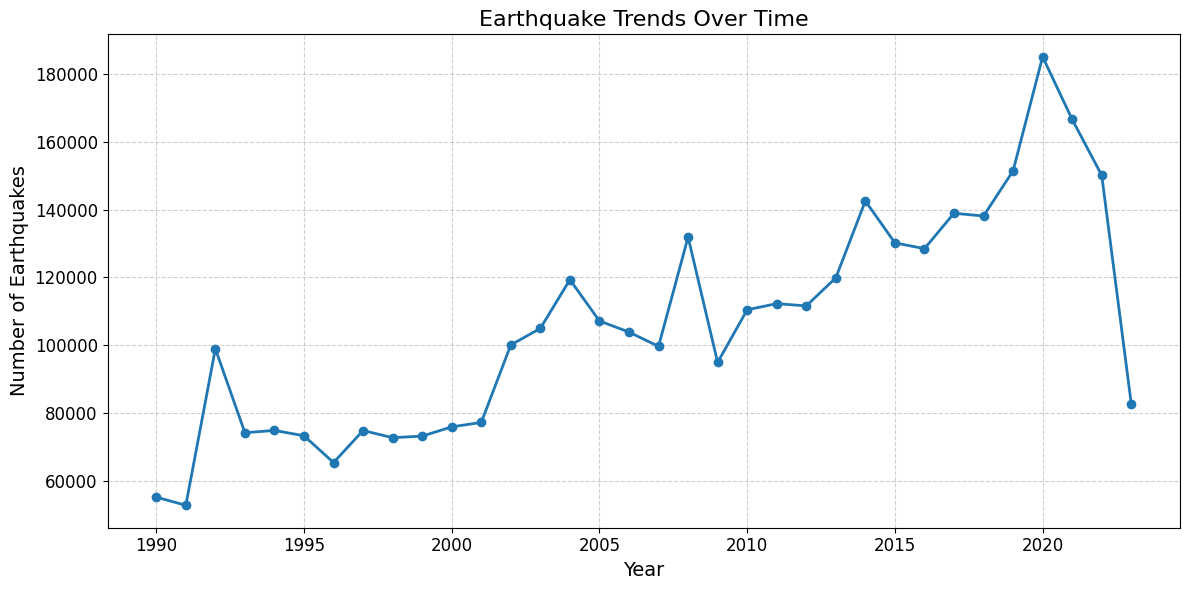

In [ ]:
earthquake_trends = (
    analysis_rdd
    .map(lambda row: (row['date'].year, 1))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

# Sort trends by year and add to lists
earthquake_trends = sorted(earthquake_trends, key=lambda x: x[0])
years = []
counts = []
for record in earthquake_trends:
    years.append(record[0])
    counts.append(record[1])

# Plotting the result
plt.figure(figsize=(12, 6))
plt.plot(years, counts, marker='o', linestyle='-', linewidth=2)
plt.title("Earthquake Trends Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Earthquakes", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Analysis 10 - Spatial Visualization

In [ ]:
import folium
from folium.plugins import HeatMap
from random import sample

# Instead of plotting the 300.000+ records, we randomly sample 25.000 of them 
# so that the kernel does not crash.
sample_size = 25000
geo_data = analysis_rdd.map(lambda row: [row['latitude_float'], row['longitude_float']]).collect()
sampled_geo_data = sample(geo_data, sample_size)

# find the mean latitude and longitude. Used for centering the world_map when opening it.
mean_latitude = analysis_rdd.map(lambda row: row['latitude_float']).mean()
mean_longitude = analysis_rdd.map(lambda row: row['longitude_float']).mean()

# Create the world map and apply the heatmap
world_map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=2)
HeatMap(sampled_geo_data, radius=10, blur=15, max_zoom=1).add_to(world_map)
world_map


#### Analysis 11 - Magnitude comparrison of tsunami-causing earthquakes with non-tsunami-causing earthquakes

In [48]:
# Separate RDDs for tsunamis and non-tsunamis
tsunami_rdd = analysis_rdd.filter(lambda row: row['tsunami_bool'])
non_tsunami_rdd = analysis_rdd.filter(lambda row: not row['tsunami_bool'])

# Calculate average magnitude for each group
tsunami_avg_magnitude = tsunami_rdd.map(lambda row: row['magnitude_float']).mean()
non_tsunami_avg_magnitude = non_tsunami_rdd.map(lambda row: row['magnitude_float']).mean()

print(f"Average Magnitude for Tsunami-Triggered Earthquakes: {tsunami_avg_magnitude:.2f}")
print(f"Average Magnitude for Non-Tsunami Earthquakes: {non_tsunami_avg_magnitude:.2f}")


Average Magnitude for Tsunami-Triggered Earthquakes: 5.22
Average Magnitude for Non-Tsunami Earthquakes: 1.74


#### Analysis 12 - The 10 most frequent locations 

In [49]:
# Count occurrences of each location
location_counts = (
    analysis_rdd
    .map(lambda row: (row['place_str'], 1))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

# Sort and take the top 10 most frequent locations
top_10_locations = sorted(location_counts, key=lambda x: -x[1])[:10]

# Print results
print("Top 10 Most Frequent Locations:")
for location, count in top_10_locations:
    print(f"{location}: {count}")


Top 10 Most Frequent Locations:
6 km W of Cobb, California: 26491
7 km W of Cobb, California: 25822
8 km W of Cobb, California: 16526
37 km NNE of Amboy, Washington: 15637
9 km W of Cobb, California: 12113
Rat Islands, Aleutian Islands, Alaska: 9068
6 km WSW of Cobb, California: 8461
9 km WNW of Cobb, California: 8435
5 km W of Cobb, California: 8267
45 km ESE of Beatty, Nevada: 8046


# 3. Data Serving - Part 2: Machine Learning based Predictions

There are several use cases for the cleaned data. For instance, we can use the data to train an ML algrotihm to predict future earthquakes. We want their coordinates and their magnitudes.

One way of doing this, which might not be the best approach, is to create one model for each of the fields that we want to predict, and to combine their outputs. This is what we have implemented so far.

Another approach is to use a different algorithm designed to give more than one field as output.

In [21]:
from pyspark.sql.functions import hour, dayofmonth, month, year

#Splitting the data into training and test data
train_df, test_df = df.randomSplit([0.8, 0.2], seed = 1)
print(f"Number of Rows in train_df: {train_df.count()}")
print(f"Number of Rows in test_df: {test_df.count()}")

# Extract date features. Chat GPT helped with this.
train_df = train_df.withColumn("hour", hour("date")) \
                   .withColumn("day", dayofmonth("date")) \
                   .withColumn("month", month("date")) \
                   .withColumn("year", year("date"))

test_df = test_df.withColumn("hour", hour("date")) \
                 .withColumn("day", dayofmonth("date")) \
                 .withColumn("month", month("date")) \
                 .withColumn("year", year("date"))

Number of Rows in train_df: 2879587


Number of Rows in test_df: 720749


Now we need to prepare the features with transformers:

In [22]:
from pyspark.ml.feature import VectorAssembler
vector_assembler_1 = VectorAssembler(inputCols=["magnitude_float"], outputCol="features")
vector_train_df_magnitude = vector_assembler_1.transform(train_df)


vector_assembler_2 = VectorAssembler(inputCols=["longitude_float"], outputCol="features")
vector_train_df_longitude = vector_assembler_1.transform(train_df)

vector_assembler_3 = VectorAssembler(inputCols=["latitude_float"], outputCol="features")
vector_train_df_latitude = vector_assembler_1.transform(train_df)

#Displaying a couple of the magnitude rows
vector_train_df_magnitude.select("magnitude_float", "features", "longitude_float", "latitude_float").show(2)


+---------------+--------------------+---------------+--------------+
|magnitude_float|            features|longitude_float|latitude_float|
+---------------+--------------------+---------------+--------------+
|           0.89|[0.8899999856948853]|       -122.796|        38.819|
|           1.51|[1.5099999904632568]|       -121.732|    36.9903333|
+---------------+--------------------+---------------+--------------+
only showing top 2 rows



We want to use the random forest model. Our vector assemblers are now in a format that the random forest function expects. The random forest function builds and estimator, which we use next.

In [23]:
from pyspark.ml.regression import RandomForestRegressor


rf_magnitude = RandomForestRegressor(featuresCol="features", labelCol="magnitude_float")
rf_longitude = RandomForestRegressor(featuresCol="features", labelCol="longitude_float")
rf_latitude = RandomForestRegressor(featuresCol="features", labelCol="latitude_float")

We used the RFormula syntax for building the pipelines as it allows us to easily decide which features and labels we want to use. After, we fit the training data into a model, and then genereate the predictions.

In [24]:
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline

r_formula_magnitude = RFormula(
    formula="magnitude_float ~ longitude_float + latitude_float + depth_float + hour + day + month + year",
    featuresCol="features",
    labelCol="magnitude_float",
    handleInvalid="skip"
)
pipeline_1 = Pipeline(stages=[r_formula_magnitude, rf_magnitude])
pipelineModel_1 = pipeline_1.fit(train_df)
prediction_df_1 = pipelineModel_1.transform(test_df)


r_formula_longitude = RFormula(
    formula="longitude_float ~ magnitude_float + latitude_float + depth_float + hour + day + month + year",
    featuresCol="features",
    labelCol="latitude_float",
    handleInvalid="skip"
)
pipeline_2 = Pipeline(stages=[r_formula_longitude, rf_longitude])
pipelineModel_2 = pipeline_2.fit(train_df)
prediction_df_2 = pipelineModel_2.transform(test_df)


r_formula_latitude = RFormula(
    formula="latitude_float ~ magnitude_float + longitude_float + depth_float + hour + day + month + year",
    featuresCol="features",
    labelCol="latitude_float",
    handleInvalid="skip"
)
pipeline_3 = Pipeline(stages=[r_formula_latitude, rf_latitude])
pipelineModel_3 = pipeline_3.fit(train_df)
prediction_df_3 = pipelineModel_3.transform(test_df)


prediction_df_1.select("features", "magnitude_float", "prediction").show(5)
prediction_df_3.select("features", "latitude_float", "prediction").show(5)
prediction_df_2.select("features", "longitude_float", "prediction").show(5)


+--------------------+---------------+------------------+
|            features|magnitude_float|        prediction|
+--------------------+---------------+------------------+
|[-116.499,33.151,...|           0.82|1.3305388769989999|
|[-121.1463333,36....|           0.86|1.3012234096078388|
|[-122.7681667,38....|           1.29| 1.331959890777722|
|[8.112,44.415,10....|            1.7|2.8294675721275544|
|[-122.236,46.2423...|            0.9|1.3976150921100976|
+--------------------+---------------+------------------+
only showing top 5 rows



+--------------------+--------------+------------------+
|            features|latitude_float|        prediction|
+--------------------+--------------+------------------+
|[0.81999999284744...|        33.151|  37.1077606995629|
|[0.86000001430511...|    36.5613333| 37.26970443601883|
|[1.28999996185302...|        38.781| 38.67957902072999|
|[1.70000004768371...|        44.415|35.415282592846566|
|[0.89999997615814...|    46.2423333| 38.79535914983665|
+--------------------+--------------+------------------+
only showing top 5 rows



+--------------------+---------------+-------------------+
|            features|longitude_float|         prediction|
+--------------------+---------------+-------------------+
|[0.81999999284744...|       -116.499|-116.70542834978403|
|[0.86000001430511...|   -121.1463333|-117.22327229250291|
|[1.28999996185302...|   -122.7681667|-117.22327229250291|
|[1.70000004768371...|          8.112| -94.28785522425676|
|[0.89999997615814...|       -122.236|-114.24397547856465|
+--------------------+---------------+-------------------+
only showing top 5 rows



As we have three different data frames, we need to combine their results. We do this by giving each record an acending ID for all three DataFrames, and then combine the records on their IDs. We do this to get the records in a simiular order as they were originally.

In [25]:
from pyspark.sql.functions import monotonically_increasing_id

# Adding an id column to each DataFrame
prediction_df_1 = prediction_df_1.withColumn("id", monotonically_increasing_id())
predicted_magnitude = prediction_df_1.select("id", prediction_df_1["prediction"].alias("predicted_magnitude"))

prediction_df_2 = prediction_df_2.withColumn("id", monotonically_increasing_id())
predicted_longitude = prediction_df_2.select("id", prediction_df_2["prediction"].alias("predicted_longitude"))

prediction_df_3 = prediction_df_3.withColumn("id", monotonically_increasing_id())
predicted_latitude = prediction_df_3.select("id", prediction_df_3["prediction"].alias("predicted_latitude"))

# Joining DataFrames on the id column
combined_predictions = (
    predicted_magnitude
    .join(predicted_longitude, on="id", how="inner")
    .join(predicted_latitude, on="id", how="inner")
)

# Selecting the required columns
combined_predictions.select("predicted_magnitude", "predicted_longitude", "predicted_latitude").show(5)


+-------------------+-------------------+------------------+
|predicted_magnitude|predicted_longitude|predicted_latitude|
+-------------------+-------------------+------------------+
| 1.3305388769989999|-116.70542834978403|  37.1077606995629|
| 1.4398369379909552|-147.54137180391166| 51.92964589805731|
| 1.3012234096078388|-117.22327229250291| 38.49342399917707|
| 1.3003991328524382|-117.22327229250291| 38.57534259540331|
|  2.047772547531527|-142.36473250059404| 51.95679041594265|
+-------------------+-------------------+------------------+
only showing top 5 rows



We can convert the newely generated dataframe into a list, which we can use for plotting.

In [26]:
formatted_predictions = (
    combined_predictions
    .select("predicted_longitude", "predicted_latitude", "predicted_magnitude")
    .rdd
    .map(lambda row: ((row["predicted_longitude"], row["predicted_latitude"]), row["predicted_magnitude"]))
    .collect()
)

# Displaying the formatted list
print(formatted_predictions[0:10])

[((-116.70542834978403, 37.1077606995629), 1.3305388769989999), ((-147.54137180391166, 51.92964589805731), 1.4398369379909552), ((-117.22327229250291, 38.49342399917707), 1.3012234096078388), ((-117.22327229250291, 38.57534259540331), 1.3003991328524382), ((-142.36473250059404, 51.95679041594265), 2.047772547531527), ((-117.22327229250291, 38.67957902072999), 1.3601920741152342), ((-116.70542834978403, 38.53191272577926), 1.347616602814703), ((-116.70542834978403, 38.53191272577926), 1.3003991328524382), ((-117.22327229250291, 37.85449090942457), 1.3484408795701035), ((-117.22327229250291, 38.49342399917707), 1.3012234096078388)]


Plot the predictions in a heat map using folium. 

In [27]:
import folium
from folium.plugins import HeatMap

sample_size = 5000
predictions = sample(formatted_predictions, sample_size)

map_earthquakes = folium.Map(location=[0,0], zoom_start=2)

# Function to get color based on magnitude
def get_color(magnitude):
    if magnitude < 2.0:
        return 'green'
    elif 2.0 < magnitude <= 3.0:
        return 'yellow'
    elif 3.0 < magnitude <= 4.0:
        return 'orange'
    else:
        return 'red'

# Add circle markers for each prediction
for coordinates, magnitude in predictions:
    folium.CircleMarker(
        location=[coordinates[1], coordinates[0]],
        radius= 0.5*magnitude, 
        color=get_color(magnitude),
        fill=True,
        fill_color=get_color(magnitude),
        fill_opacity=0.7,
        popup=f"Magnitude: {magnitude:.2f}"
    ).add_to(map_earthquakes)

# Create a HeatMap layer
heat_data = [[data[0][1], data[0][0], data[1]] for data in predictions]  # [latitude, longitude, magnitude]
HeatMap(heat_data, radius=15).add_to(map_earthquakes)

# Add a legend to the map
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 150px;
    height: 140px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
    ">
    <b>Magnitude</b><br>
    <i style="background:green; color: green; padding:5px;">&nbsp;&nbsp;&nbsp;</i> < 2.0<br>
    <i style="background:yellow; color: yellow; padding:5px;">&nbsp;&nbsp;&nbsp;</i> 2.0 - 3.0<br>
    <i style="background:orange; color: orange; padding:5px;">&nbsp;&nbsp;&nbsp;</i> 3.0 - 4.0<br>
    <i style="background:red; color: red; padding:5px;">&nbsp;&nbsp;&nbsp;</i> > 4.0
</div>
'''

map_earthquakes.get_root().html.add_child(folium.Element(legend_html))

# Display the map
map_earthquakes


#### Feature Importance

Feature Importances:
longitude_float: 0.5910
latitude_float: 0.2672
depth_float: 0.1194
year: 0.0220
hour: 0.0002
month: 0.0002
day: 0.0000


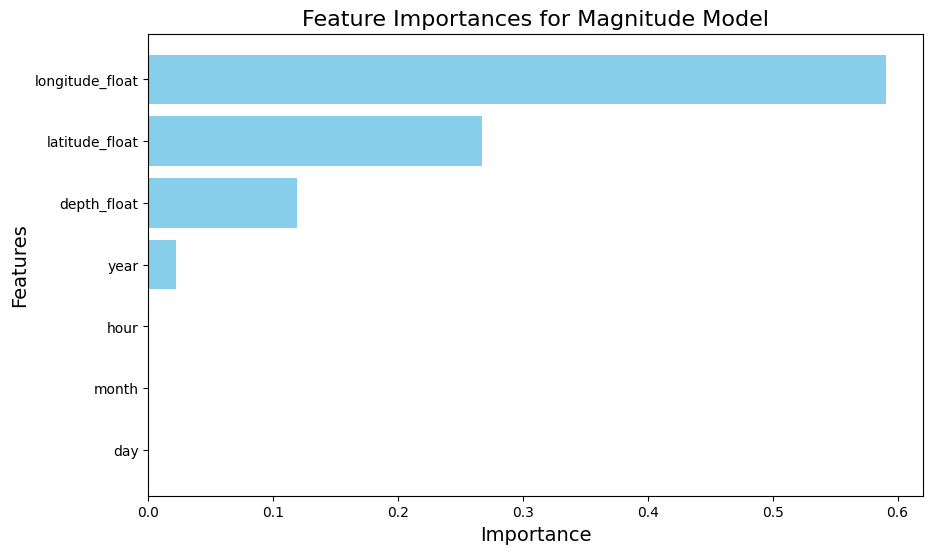

In [ ]:
rf_model = pipelineModel_1.stages[-1]
feature_importances = rf_model.featureImportances

# Access the input columns used by RFormula
input_cols = r_formula_magnitude.getFormula().split('~')[1].strip().split(' + ')  # Extract feature names

# Combine feature names and their importances
feature_importance_list = list(zip(input_cols, feature_importances.toArray()))

# Sort by importance
sorted_features = sorted(feature_importance_list, key=lambda x: -x[1])

# Print sorted feature importances
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Unzip features and their importances
features, importances = zip(*sorted_features)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importances for Magnitude Model", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
